# Nonlinear for systems of ODEs

In [240]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
torch.manual_seed(12)

## Generate training data

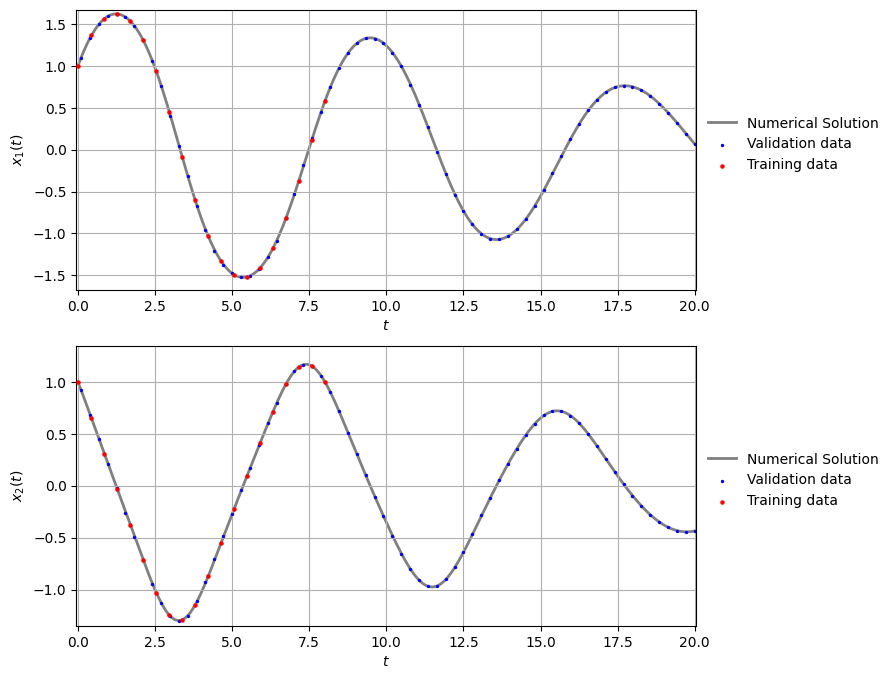

In [241]:
# Parameters and initial conditions
# w0^2 = g/L,

X0 = [1, 1]
b  = 0.2
w0 = 1

# time domain
ti = 0
tf = 20
N  = 1000

t = torch.linspace(ti, tf, N).view(-1,1)

def f1(x1, x2, t):
    if isinstance(x1, torch.Tensor) and isinstance(x1, torch.Tensor):
        return x2
    else:
        return x2

def f2(x1, x2, t):
    if isinstance(x1, torch.Tensor) and isinstance(x1, torch.Tensor):
        return -torch.sin(x1) - b*x2 + 0.3*torch.cos(0.7*t)
    else:
        return -np.sin(x1) - b*x2 + 0.3*np.cos(0.7*t)

# Numerical Solution
def ODE(X, t):
    dXdt = [f1(X[0], X[1], t), f2(X[0], X[1], t)]
    return dXdt

solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 20
t_data  = torch.linspace(ti, tf*0.4, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]
x1_data = training_data[:,0].view(-1,1)
x2_data = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 70
t_val  = torch.linspace(ti+0.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val = validation_data[:,0].view(-1,1)
x2_val = validation_data[:,1].view(-1,1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

axes[0].plot(t, x1, label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-', zorder=1)
axes[0].scatter(t_val, x1_val, color="blue", label="Validation data", s=2, zorder=2)
axes[0].scatter(t_data, x1_data, color="red", label="Training data", s=5, zorder=3)
axes[0].set_xlim(ti-.05, tf+0.05)
axes[0].set_ylim(-x1_max-.05, x1_max+0.05)
axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$x_1(t)$')
axes[0].legend(frameon=False, loc=(1.01, 0.40))
axes[0].grid()

axes[1].plot(t, x2, label="Numerical Solution", color='grey', lw=2, alpha=1, linestyle='-', zorder=1)
axes[1].scatter(t_val, x2_val, color="blue", label="Validation data", s=2, zorder=2)
axes[1].scatter(t_data, x2_data, color="red", label="Training data", s=5, zorder=3)
axes[1].set_xlim(ti-.05, tf+0.05)
axes[1].set_ylim(-x2_max-.05, x2_max+0.05)
axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$x_2(t)$')
axes[1].legend(frameon=False, loc=(1.01, 0.40))
axes[1].grid()

plt.show()

## PINN

In [242]:
def make_plot(
    i, loss_val, epochs,
    t, t_data, t_validation, t_collocation,
    solution_1, prediction_1,
    solution_2, prediction_2,
    data_1, data_2,
    validation_1, validation_2,
    x1_max, x2_max,
    training_loss, validation_loss
    
):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
    fig.suptitle(f"Training Step {i} \n Validation Loss: {loss_val.item():.4f}", fontsize=16)

    axes[0,0].plot(t, solution_1, label="Numerical Solution", color='grey', lw=1, alpha=1, linestyle='-', zorder=1)
    axes[0,0].plot(t, prediction_1, label="PINN prediction", color='black', lw=2, alpha=0.8, linestyle='-', zorder=4)
    axes[0,0].scatter(t_data, data_1, color="red", label="Training data", s=5, zorder=3)
    axes[0,0].scatter(t_validation, validation_1, color="blue", label="Validation data", s=2, zorder=2)
    axes[0,0].scatter(t_collocation, 0*torch.ones_like(t_collocation), color="green", label="Collocation Points", s=2, zorder=1)
    axes[0,0].set_xlim(ti-.05, tf+0.05)
    axes[0,0].set_ylim(-x1_max-.05, x1_max+0.05)
    axes[0,0].set_xlabel('$t$')
    axes[0,0].set_ylabel('$x_1(t)$')
    axes[0,0].legend(frameon=False, loc=(1.01, 0.48))
    axes[0,0].grid()

    axes[1,0].plot(t, solution_2, label="Numerical Solution", color='grey', lw=1, alpha=1, linestyle='-', zorder=1)
    axes[1,0].scatter(t_validation, validation_2, color="blue", label="Validation data", s=2, zorder=2)
    axes[1,0].scatter(t_data, data_2, color="red", label="Training data", s=5, zorder=3)
    axes[1,0].scatter(t_collocation, 0*torch.ones_like(t_collocation), color="green", label="Collocation Points", s=2, zorder=1)
    axes[1,0].plot(t, prediction_2, label="PINN prediction", color='black', lw=2, alpha=0.8, linestyle='-', zorder=4)
    axes[1,0].set_xlim(ti-.05, tf+0.05)
    axes[1,0].set_ylim(-x2_max-.05, x2_max+0.05)
    axes[1,0].set_xlabel('$t$')
    axes[1,0].set_ylabel('$x_2(t)$')
    axes[1,0].grid()
    
    axes[0,1].plot(np.arange(i+1), training_loss, label="Training Loss", color='red', lw=1)
    axes[0,1].plot(np.arange(i+1), validation_loss, label="validation Loss", color='blue', lw=1)
    axes[0,1].set_xlabel('Training Steps')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].set_xlim(0, epochs)
    axes[0,1].set_ylim(1e-6, 1e2)
    axes[0,1].set_yscale('log')
    axes[0,1].grid()
    axes[0,1].legend(frameon=False, loc=(0.7, 1))
    
    
    X_max = max(x1_max, x2_max)
    axes[1,1].plot(t, torch.abs((solution_1 - prediction_1)/solution_1), label="Error in $x_1$", color='red', lw=1)
    axes[1,1].plot(t, torch.abs((solution_2 - prediction_2)/solution_2), label="Error in $x_2$", color='blue', lw=1)
    axes[1,1].set_xlabel('t')
    axes[1,1].set_ylabel('relative error')
    axes[0,1].set_ylim(1e-6, 1e2)
    axes[1,1].set_yscale('log')
    axes[1,1].grid()
    axes[1,1].legend(frameon=False, loc=(0.7, 1))
    
    plt.tight_layout()

In [243]:
# Define Neural Network Structure

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self):
        super().__init__()
        self.scale = lambda T : (T - ti)/(tf-ti)
        
        self.fcs = nn.Sequential(*[nn.Linear(1, 32), nn.Tanh()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()]),
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()]),
                        nn.Sequential(*[nn.Linear(32, 32), nn.Tanh()])
                    ])
        self.fce = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [244]:
# Define the sample locations for physics loss
N_phys = 50
t_physics = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)

# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

Training step 0
Total Training Loss = 3.2079e+00, 
ODE Training Loss = 2.3519%, Data Training Loss = 62.1782%, derivative Training Loss = 35.4699%
----------------------------------------------


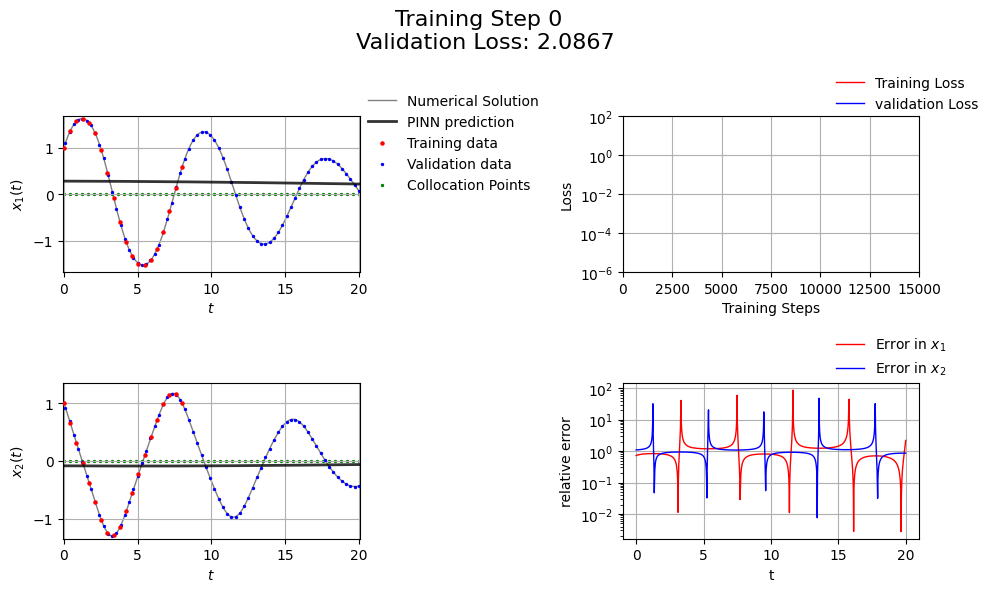

Training step 1000
Total Training Loss = 7.7835e-04, 
ODE Training Loss = 81.9356%, Data Training Loss = 10.9056%, derivative Training Loss = 7.1588%
----------------------------------------------
Training step 2000
Total Training Loss = 4.6482e-03, 
ODE Training Loss = 13.9692%, Data Training Loss = 61.2205%, derivative Training Loss = 24.8103%
----------------------------------------------
Training step 3000
Total Training Loss = 5.5983e-05, 
ODE Training Loss = 83.2869%, Data Training Loss = 6.3786%, derivative Training Loss = 10.3345%
----------------------------------------------
Training step 4000
Total Training Loss = 9.1785e-05, 
ODE Training Loss = 44.6927%, Data Training Loss = 41.7933%, derivative Training Loss = 13.5140%
----------------------------------------------
Training step 5000
Total Training Loss = 4.7739e-04, 
ODE Training Loss = 7.3275%, Data Training Loss = 56.5492%, derivative Training Loss = 36.1233%
----------------------------------------------


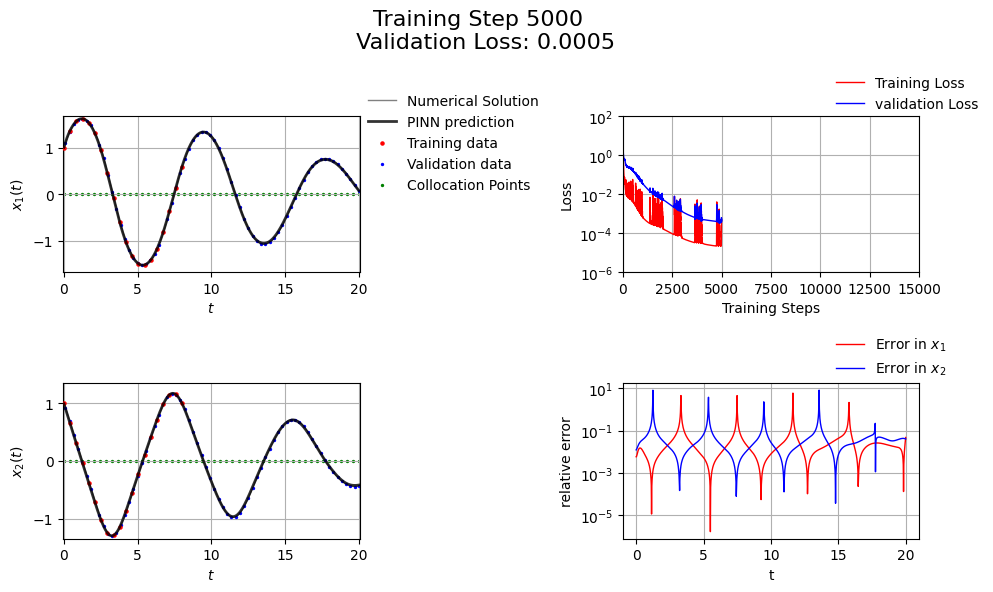

Training step 6000
Total Training Loss = 5.8367e-05, 
ODE Training Loss = 23.9263%, Data Training Loss = 42.5789%, derivative Training Loss = 33.4948%
----------------------------------------------
Training step 7000
Total Training Loss = 5.9859e-05, 
ODE Training Loss = 24.9434%, Data Training Loss = 53.0070%, derivative Training Loss = 22.0496%
----------------------------------------------
Training step 8000
Total Training Loss = 1.6505e-04, 
ODE Training Loss = 15.3234%, Data Training Loss = 58.0128%, derivative Training Loss = 26.6638%
----------------------------------------------
Training step 9000
Total Training Loss = 1.4663e-05, 
ODE Training Loss = 61.7602%, Data Training Loss = 21.5475%, derivative Training Loss = 16.6923%
----------------------------------------------
Training step 10000
Total Training Loss = 1.3289e-05, 
ODE Training Loss = 58.3872%, Data Training Loss = 18.1125%, derivative Training Loss = 23.5004%
----------------------------------------------


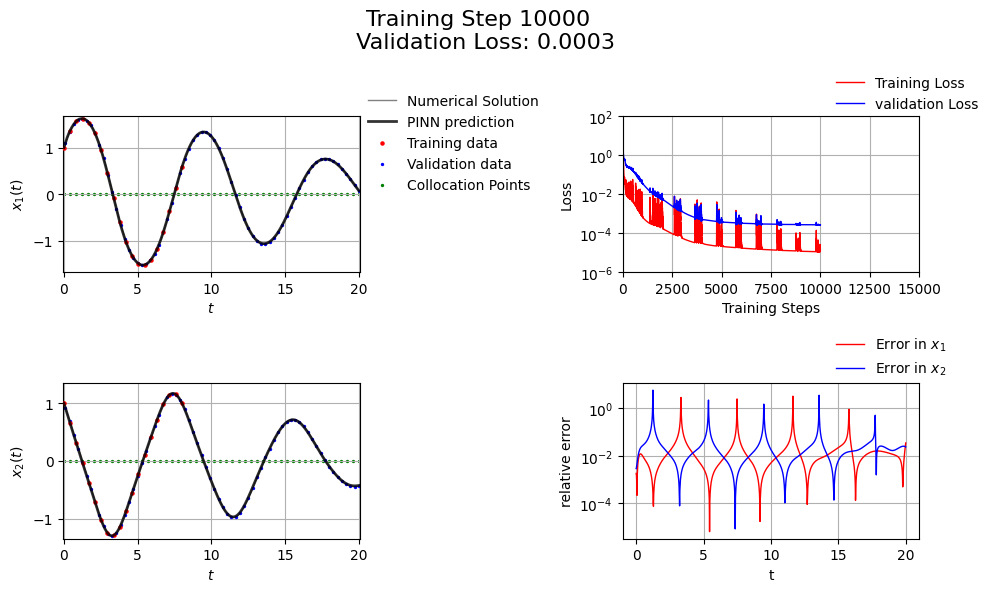

Training step 11000
Total Training Loss = 1.0882e-05, 
ODE Training Loss = 55.8662%, Data Training Loss = 19.9992%, derivative Training Loss = 24.1346%
----------------------------------------------
Training step 12000
Total Training Loss = 1.4014e-05, 
ODE Training Loss = 42.0835%, Data Training Loss = 22.3924%, derivative Training Loss = 35.5241%
----------------------------------------------
Training step 13000
Total Training Loss = 9.6041e-06, 
ODE Training Loss = 54.4198%, Data Training Loss = 16.5271%, derivative Training Loss = 29.0531%
----------------------------------------------
Training step 14000
Total Training Loss = 8.1993e-06, 
ODE Training Loss = 58.2874%, Data Training Loss = 16.7846%, derivative Training Loss = 24.9280%
----------------------------------------------
Training step 15000
Total Training Loss = 7.8217e-06, 
ODE Training Loss = 57.1321%, Data Training Loss = 16.0907%, derivative Training Loss = 26.7772%
----------------------------------------------


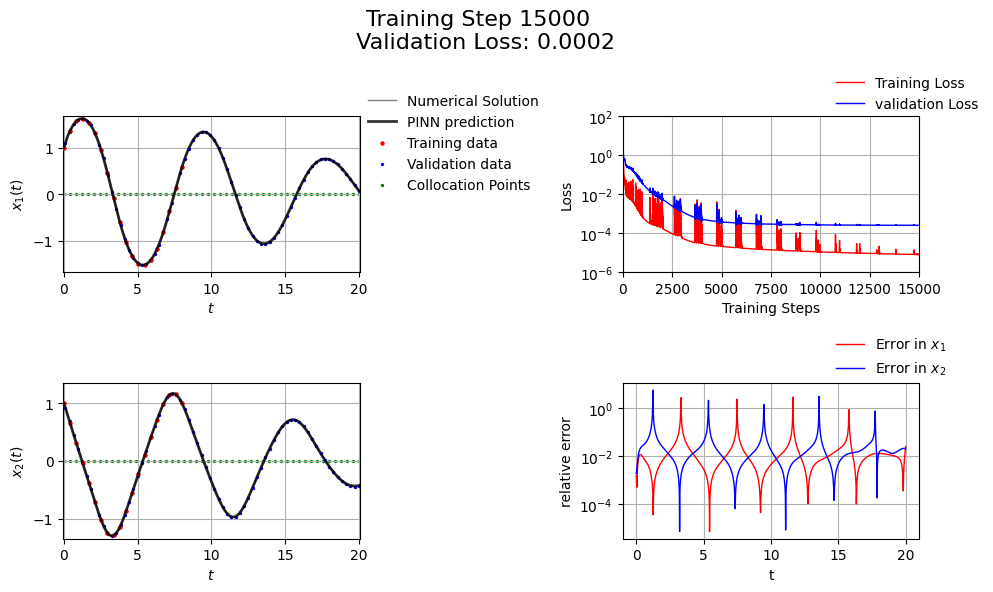

In [ ]:
# PINN
torch.manual_seed(123)

# Define PINN model. 1 input, 1 output, 3 hidden layers of 32 nodes.
PINN = FCN()

# Uses the Adam optimizer
optimizer = torch.optim.Adam(PINN.parameters(), lr = 1e-2)

# Exponential scheduler, multiplies learning rate (lr) by gamma every 2000 epochs; set gamma to 1 to disable
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75)

# Number of training steps
epochs = 15_000 + 1

# Weights for loss function
l1, l2  = 1e0, 1e0

# stores loss values
training_loss, validation_loss = [], []
physics_losses, data_losses, derivative_losses = [], [], []


torch.autograd.set_detect_anomaly(False)
for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data loss for position
    U  = PINN(t_training)
    u1 = U[:,0].view(-1,1)
    u2 = U[:,1].view(-1,1)
    data_loss = ((u1 - x1_data)**2 + (u2 - x2_data)**2).mean()
    
    du1 = torch.autograd.grad(u1, t_training, torch.ones_like(u1), create_graph=True, retain_graph=True)[0]
    du2 = torch.autograd.grad(u2, t_training, torch.ones_like(u2), create_graph=True, retain_graph=True)[0]
    derivative_loss = ((du1 - f1(x1_data, x2_data,t_training))**2 + (du2 - f2(x1_data, x2_data,t_training))**2).mean()
    
    # Compute the ODE loss
    V   = PINN(t_physics)
    v1  = V[:,0].view(-1,1)
    v2  = V[:,1].view(-1,1)
    dv1 = torch.autograd.grad(v1, t_physics, torch.ones_like(v1), create_graph=True)[0]
    dv2 = torch.autograd.grad(v2, t_physics, torch.ones_like(v2), create_graph=True)[0]
    loss_ODE = ((dv1 - f1(v1, v2, t_physics))**2 + (dv2 - f2(v1,v2,t_physics))**2).mean()
    
    # Compute total loss
    loss = data_loss + l1*derivative_loss + l2*loss_ODE
    
    training_loss.append(loss.item())
    physics_losses.append(loss_ODE.item())
    data_losses.append(data_loss.item())
    derivative_losses.append(derivative_loss.item())
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    
    # every 1000 epochs, multiply learning rate by gamma
    if (i+1) % 1000 == 0: scheduler.step()
    
    # ===
    # Validation
    # ===
    PINN.eval()

    U_val = PINN(t_validation)
    u1_val = U_val[:,0].view(-1,1)
    u2_val = U_val[:,1].view(-1,1)
    
    loss_value_val = torch.mean((u1_val - x1_val)**2 + (u2_val - x2_val)**2)

    du1_val = torch.autograd.grad(u1_val, t_validation, torch.ones_like(u1_val), create_graph=True)[0]
    du2_val = torch.autograd.grad(u2_val,  t_validation, torch.ones_like(u2_val),  create_graph=True)[0]
    loss_ODE_val = torch.mean((du1_val - f1(x1_val, x2_val, t_validation))**2 + (du2_val - f2(x1_val, x2_val, t_validation))**2)
    
    loss_val = loss_value_val + l1*loss_ODE_val
    validation_loss.append(loss_val.item())
    
    # ===
    # Plotting
    # ===
    
    if (i % 1_000) == 0: 
        P  = PINN(t).detach()
        make_plot(
            i=i, loss_val=loss_val, epochs=epochs,
            t=t, t_data=t_data, t_validation=t_val, t_collocation=t_physics.detach(),
            solution_1=x1, prediction_1=P[:,0],
            solution_2=x2, prediction_2=P[:,1],
            data_1=x1_data, data_2=x2_data,
            validation_1=x1_val, validation_2=x2_val,
            x1_max=x1_max, x2_max=x2_max,
            training_loss=training_loss, validation_loss=validation_loss
        )
        print(f"Training step {i}")
        print(f"Total Training Loss = {loss.item():.4e}, \n"+
              f"ODE Training Loss = {l2*loss_ODE.item()/loss * 100:.4f}%, "+
              f"Data Training Loss = {data_loss.item()/loss * 100:.4f}%, "+
              f"derivative Training Loss = {l1*derivative_loss.item()/loss * 100:.4f}%")
        print("----------------------------------------------")
        
        if i == (epochs-1):
            plt.savefig("pinn_ode_solution.png", dpi=300)
            plt.show()
        elif (i % 5_000) == 0:
            plt.show()
        else: 
            plt.close("all")

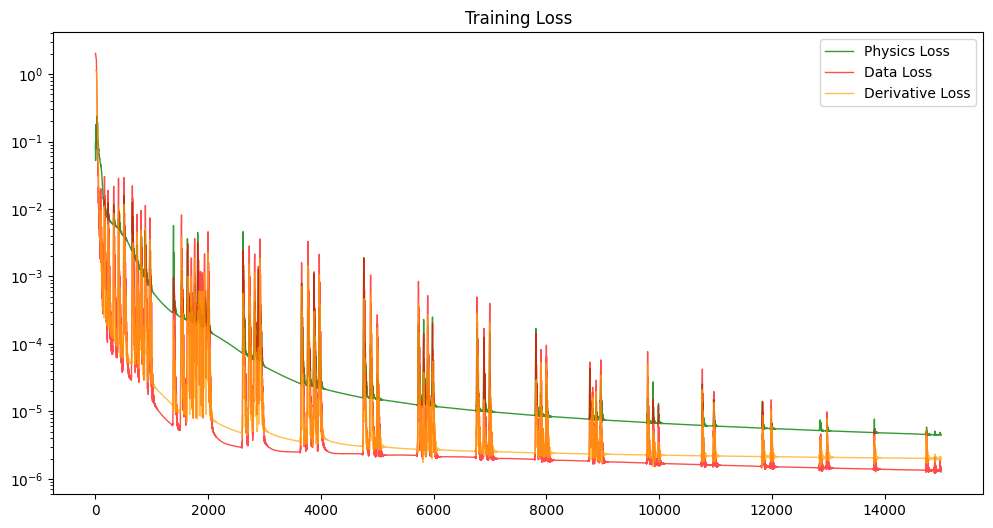

In [246]:
plt.subplots(figsize=(12,6))
plt.plot(np.arange(epochs), physics_losses, label="Physics Loss", color='green', lw=1, alpha=0.8, linestyle = '-')
plt.plot(np.arange(epochs), l2*torch.tensor(data_losses), label="Data Loss", color='red', lw=1, alpha=0.7)
plt.plot(np.arange(epochs), l1*torch.tensor(derivative_losses), label="Derivative Loss", color='orange', lw=1, alpha=0.7)
plt.title("Training Loss")
plt.legend()
plt.yscale('log')
plt.savefig('loss.png')
plt.show()

In [247]:
print(dv1.abs().mean().item())

0.5780362486839294


In [248]:
print(dv2.abs().mean().item())

0.48139938712120056
